## Environment

We use shared GPUs for AI workloads in virtualization environments. It is assumed you have `netapp_dataops_cli.py` and [MLflow](https://mlflow.org/docs/latest/index.html) backend set up already. You may use other MLOps platforms to achieve similar capability.

In this example we demonstrate an AI workflow in Jupyter Notebooks using Keras and MLflow. This notebook's goal is to give you a key understanding on how to use the DataOps Toolkit with MLFlow for dataset-to-model traceability.

For the dataset, we'll take parts of the [TLC Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) which is publicly available. The dataset contains more than 3 million records of NYC taxi rides.

## Importing of Libraries

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import datetime as dt
import mlflow
from netapp_dataops.traditional import clone_volume, create_volume, delete_volume, list_volumes, mount_volume, create_snapshot, delete_snapshot, list_snapshots, restore_snapshot, list_cloud_sync_relationships, sync_cloud_sync_relationship, list_snap_mirror_relationships, sync_snap_mirror_relationship, push_directory_to_s3, push_file_to_s3, pull_bucket_from_s3, pull_object_from_s3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  


## DataOps Toolkit: Listing & Cloning Volumes

By running `list_volumes()` command, we see current Volumes and their Size, Mount Point, Source Volume, and other information.

In [195]:
volumes = list_volumes(print_output=True)

Volume Name                                       Size     Type       NFS Mount Target                                                 FlexCache    Clone    Source Volume    Source Snapshot
------------------------------------------------  -------  ---------  ---------------------------------------------------------------  -----------  -------  ---------------  -----------------
taxiDataInstantCopy1                              5.0GB    flexgroup  192.168.0.131:/taxiDataInstantCopy1                              no           yes      taxiData         timePointData1
taxiDataCleaned                                   200.0MB  flexvol    192.168.0.131:/taxiDataCleaned                                   no           no
trident_pvc_68373183_9fd7_4498_a92a_57fa829e0973  100.0GB  flexvol    192.168.0.131:/trident_pvc_68373183_9fd7_4498_a92a_57fa829e0973  no           no
trident_pvc_42fcccd4_f642_4028_a8d2_5adbf6e83059  20.0GB   flexvol    192.168.0.131:/trident_pvc_42fcccd4_f642_4028_a8d2_5adbf6

Here our gold source is `taxiData`. Therefore, we created many volumes off of this it and took snapshots to preserve experiment states. In this case each Volume is 5GB. Each data scientist on your team can conduct experiments in her own volume without affecting other members' and the gold source.

The folder `taxiData` contains liveDemo.csv, which is our dataset of choice.

In [13]:
! ls ~/taxiData

liveDemo.csv


In [196]:
create_snapshot(volume_name="taxiData", snapshot_name="timePointData3", print_output=True)

Creating snapshot 'timePointData3'.
Snapshot created successfully.


In [197]:
clone_volume(new_volume_name="taxiDataInstantCopy3", source_volume_name="taxiData", source_snapshot_name="timePointData3", 
            mountpoint="~/taxiDataInstantCopy3", print_output=True)

Creating clone volume 'taxiDataInstantCopy3' from source volume 'taxiData'.
Clone volume created successfully.
Mounting volume 'taxiDataInstantCopy3' at '~/taxiDataInstantCopy3'.
Volume mounted successfully.


We've created a near-instantaneous snapshot of `taxiData` and cloned `taxiData` volume.

At this moment a new data scientist is ready to start her/his data exploration in their own environment.

## Reading Data

In [89]:
taxiData = pd.read_csv("~/taxiDataInstantCopy2/liveDemo.csv")
taxiData["Unique"]= taxiData.index
taxiData["date"] = pd.to_datetime(taxiData["lpep_pickup_datetime"], format="%y-%m-%d", exact=False)
taxiData.set_index("date", inplace=True)
taxiData.sort_values("date", inplace=True)

In [15]:
taxiData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3324003 entries, 1981-06-24 to 2062-08-15
Data columns (total 6 columns):
 #   Column                Dtype  
---  ------                -----  
 0   VendorID              float64
 1   lpep_pickup_datetime  object 
 2   passenger_count       float64
 3   trip_distance         float64
 4   fare_amount           float64
 5   Unique                int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 177.5+ MB


Let's name the data scientist Erika. In the cells above Erika reads the CSV file and sets an index column to be the date. However, `taxiData.info()` shows there are some oddities: the `DateTimeIndex` ranges from 1981 to 2062!

She decides to visualize the data by first plotting out rides per day.

### Rides per Day

<AxesSubplot:xlabel='date'>

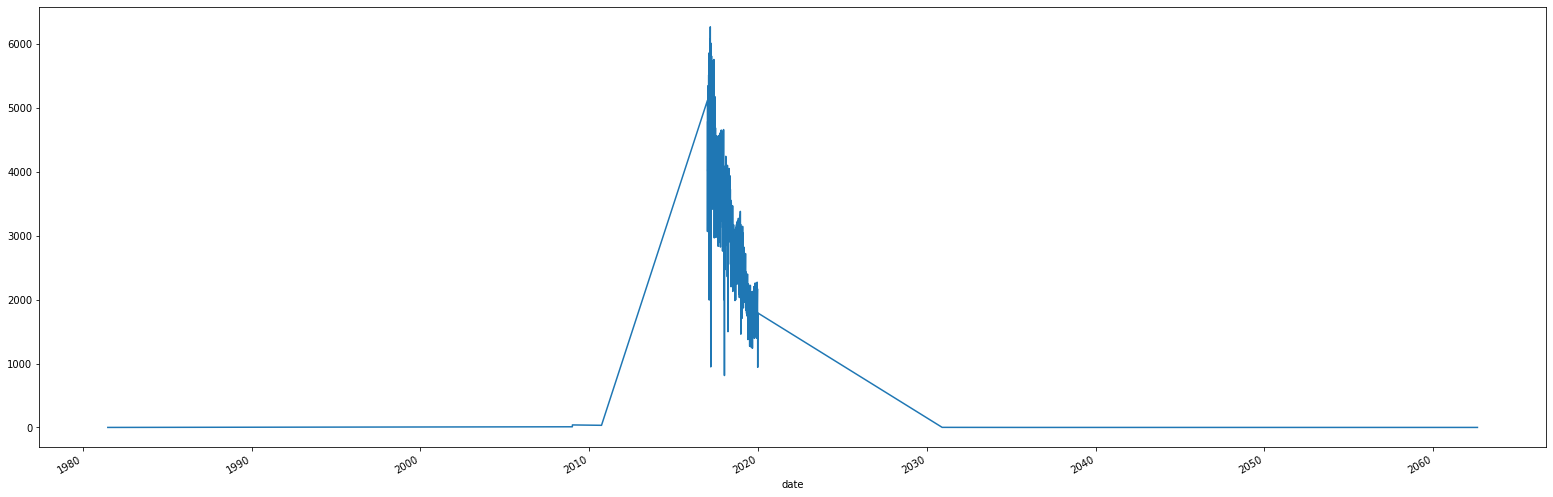

In [20]:
taxiData.groupby("date").nunique()["Unique"].plot(figsize=(27,9))

### Costs per Ride

<AxesSubplot:xlabel='date'>

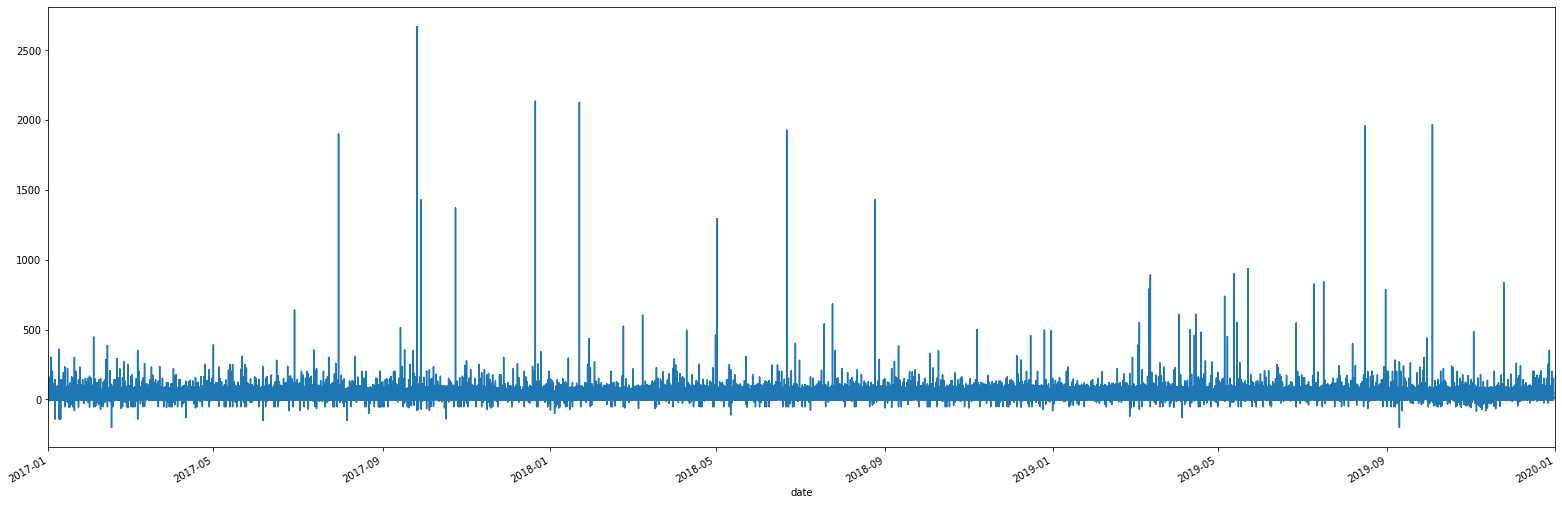

In [21]:
taxiData["fare_amount"].plot(figsize=(27,9), xlim=(dt.date(2017,1,1), dt.date(2020,1,1)))

From the first plot we observe that the ride records are concentrated from 2017 to 2019.

Therefore, Erika plots the fare_amount from January 2017 to the first day of 2020.

We see some peaks, but why are some costs per ride less than 0? Maybe the gold-source wasn't perfect. We don't know how the data was collected. This is common in dealing with real-world datasets, especially as the amount of data grows in recent years.

After her EDA visualization, she cleans up the dataset by discarding unwanted records and only keep those with positive `fare_amount`.

## Cleaning of Data

In [91]:
taxiDataClean= taxiData.copy()

In order to save space and speed up training/cross-validation/testing, 
we only keep data from 2017 to 2019, and discard records with `fare_amount <= 0`

In [92]:
taxiDataClean.drop(taxiDataClean.index[taxiDataClean.index<"2017-01-01"], inplace=True)

In [93]:
taxiDataClean.drop(taxiDataClean.index[taxiDataClean.index>"2020-01-01"], inplace=True)

In [94]:
taxiDataClean= taxiDataClean[taxiDataClean.fare_amount >0]

## Visualization of the Cleaned Data

### Rides per Day

<AxesSubplot:xlabel='date'>

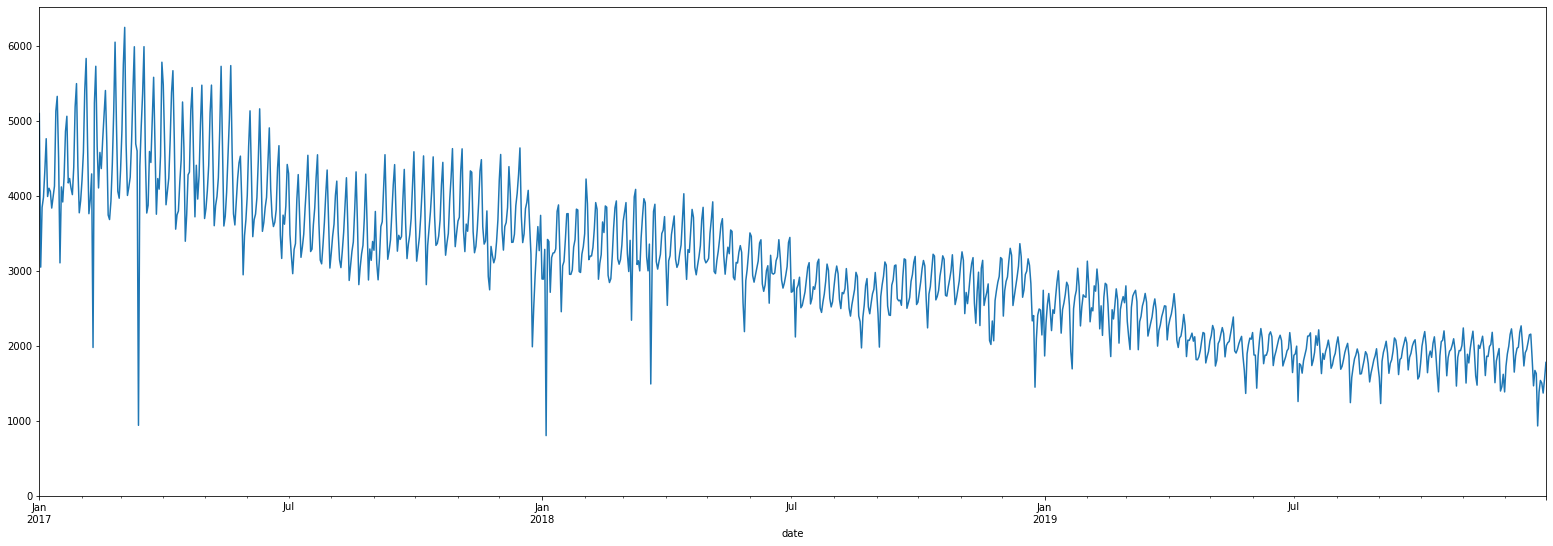

In [26]:
taxiDataClean.groupby("date").nunique()["Unique"].plot(figsize=(27,9), ylim=(0))

In this cleaned version of Rides per Day, there seems to be a trend of decreasing rides over time. Is it because of the prominence of rideshare services?

### Costs per Ride


<AxesSubplot:xlabel='date'>

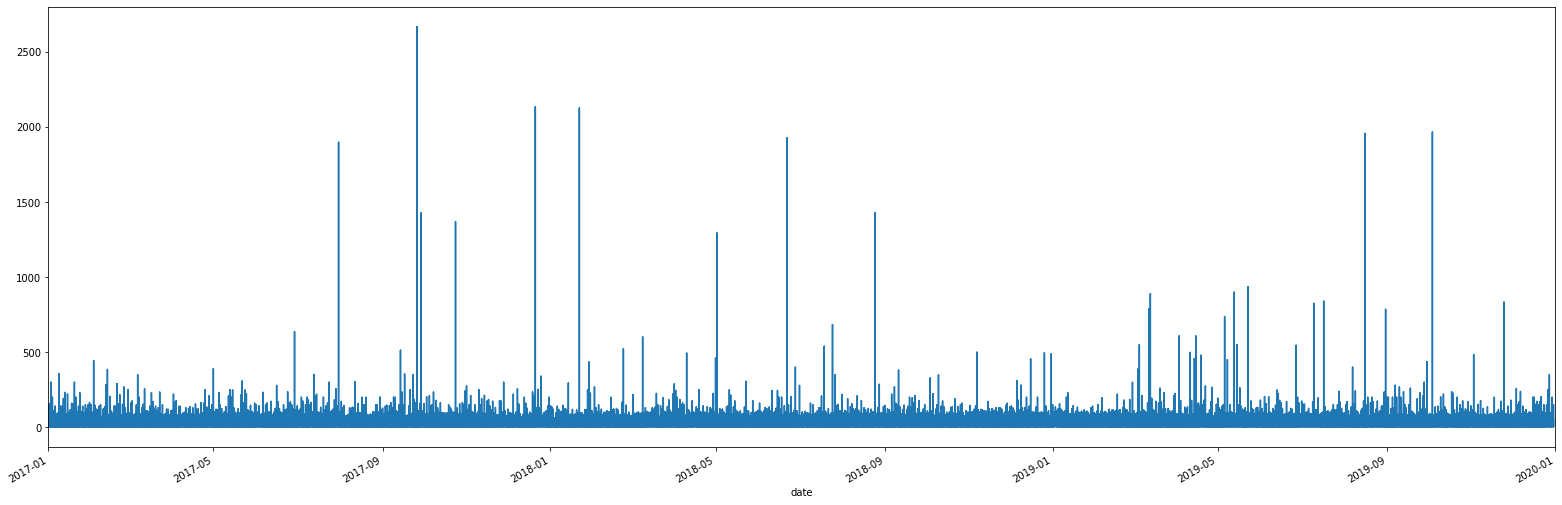

In [27]:
taxiDataClean["fare_amount"].plot(figsize=(27,9), xlim=(dt.date(2017,1,1), dt.date(2020,1,1)))

### Average Costs per Ride
If we look at the average costs per ride, it's fluctuating depending on many factors, like demand,  day of the week, etc., but it's trending upwards… due to inflation perhaps?

<AxesSubplot:xlabel='date'>

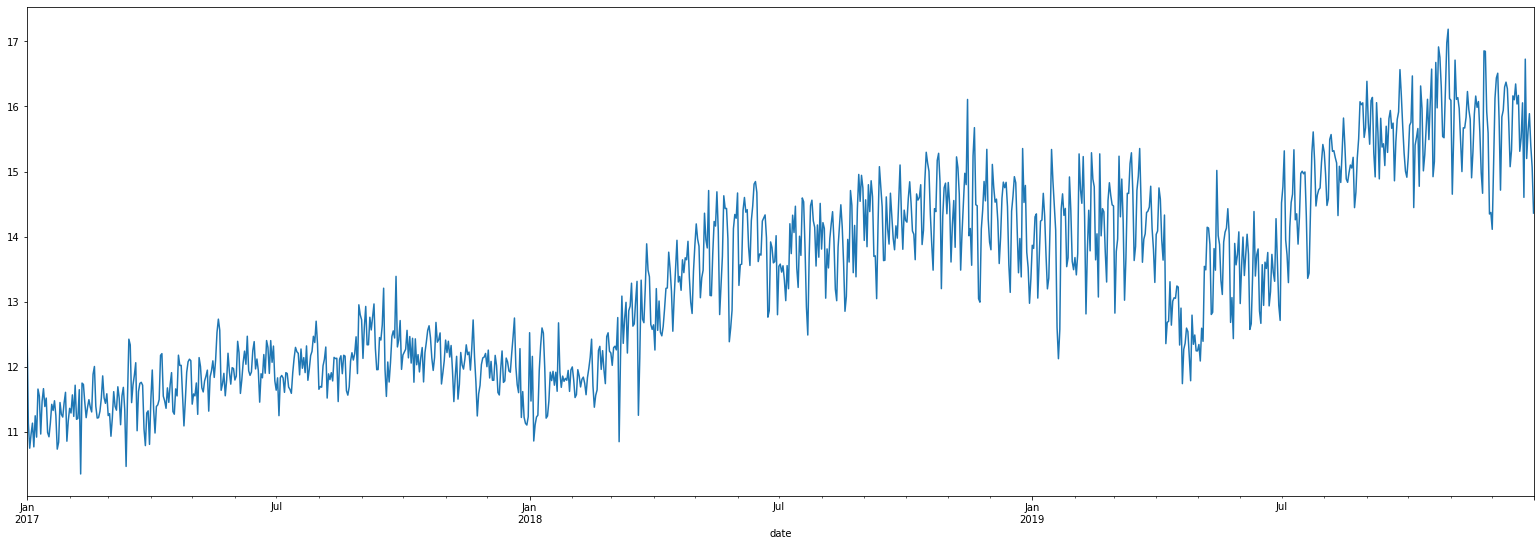

In [28]:
taxiDataClean.sort_index().groupby("date").mean()["fare_amount"].plot(figsize=(27,9))

In [149]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
taxiDataClean['trip_distance'].describe()

count   3308301.000
mean          2.998
std           5.570
min         -29.210
25%           1.030
50%           1.850
75%           3.600
max        8005.680
Name: trip_distance, dtype: float64

In fact, Erika has more feature engineering to do. `describe() trip_distance` shows negative minimum value and an outlier maximum over 8000 miles. It's twice the length of the continental United States. Impossible for NYC taxi rides!

We'll save the cleaned `dataFrame` as is without cleaning up data further.

### Saving Cleaned Data
Similar to how she started the experiment, Erika creates a volume and saves `cleanedData.csv` as a snapshot.

In [66]:
create_volume(volume_name="taxiDataCleaned", volume_size="200MB", mountpoint="~/taxiDataCleaned", print_output=True)

Creating volume 'taxiDataCleaned'.
Volume created successfully.
Mounting volume 'taxiDataCleaned' at '~/taxiDataCleaned'.
Volume mounted successfully.


In [67]:
taxiDataClean.to_csv("~/taxiDataCleaned/cleanedData.csv")

In [198]:
create_snapshot(volume_name="taxiDataCleaned", snapshot_name="cleanedData1", print_output=True)

Creating snapshot 'cleanedData1'.
Snapshot created successfully.


## More Feature Engineering in preparation for Deep Learning

Erika wants to build a Recurrent Neural Network (RNN) regression model to predict `fare_amount` based on other attributes. In an RNN, connections between nodes form a directed or undirected graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior, perfect for time series like our taxi dataset.

However, an RNN only recognize numbers, not dates in strings. We need to extract the index date into extra columns: year, month, day, and weekday.

Extract index date into separate columns for RNN training

In [119]:
taxiDataClean['year'] = pd.to_datetime(taxiDataClean.index.astype(str), errors='coerce', format='%Y-%m-%d').year
taxiDataClean['month'] = pd.to_datetime(taxiDataClean.index.astype(str), errors='coerce', format='%Y-%m-%d').month
taxiDataClean['day'] = pd.to_datetime(taxiDataClean.index.astype(str), errors='coerce', format='%Y-%m-%d').day
taxiDataClean['weekday'] = pd.to_datetime(taxiDataClean.index.astype(str), errors='coerce', format='%Y-%m-%d').weekday

In [120]:
taxiDataClean.head()

,VendorID,lpep_pickup_datetime,passenger_count,trip_distance,fare_amount,Unique,year,month,day,weekday
date,,,,,,,,,,
2017-01-01,2.0,2017-01-01 00:02:39,1.0,4.22,19.0,701962,2017,1,1,6
2017-01-01,2.0,2017-01-01 14:21:46,1.0,7.12,28.0,705377,2017,1,1,6
2017-01-01,2.0,2017-01-01 14:57:20,3.0,0.49,4.0,705376,2017,1,1,6
2017-01-01,2.0,2017-01-01 14:12:44,1.0,1.20,6.5,705375,2017,1,1,6
2017-01-01,2.0,2017-01-01 14:32:11,1.0,7.52,23.0,705374,2017,1,1,6


In `scikit-learn.model_selection`, the `train_test_split()` function separates our data randomly into different subsets according to specified proportions. Here we set 30% of the records to be a test set.

In [136]:
del taxiDataClean['lpep_pickup_datetime']

from sklearn.model_selection import train_test_split
y = taxiDataClean['fare_amount']
X = taxiDataClean.drop(columns=['fare_amount','Unique','VendorID'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

Now let's use Keras to train a Regression Model!

## Building a Regression Model with Keras
Keras is an open-source software library that provides a Python interface for artificial neural networks. It acts as an interface for the TensorFlow library. For details of model building and `KerasRegressor`, please refer to the official [Keras](https://keras.io/api/) documentation.

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

We'll build a RNN regression model to predict `fare_amount` based on `passenger_count`, `trip_distance`, `year`, `month`, `day`, `weekday`

In [188]:
def keras_baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(6,input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [189]:
seed = 7
np.random.seed(seed)
# Use KerasRegressor to create an estimator
estimator = KerasRegressor(build_fn=keras_baseline_model, 
                           nb_epoch=100, batch_size=500,verbose=0)

On a high level, a Keras `Sequential` model with input dimensions matching your training dataset has two layers. Since we want a regression model, the loss function is `mean_squared_error` instead of `accuracy`, which is for classification models.

You specify the number of training epochs and batch size for the KerasRegressor to create an estimator to be built off of `keras_baseline_model`. Next we'll train the model multiple times and find the best one.

### Cross validation to evaluate estimator performance & avoid overfitting
Cross-validation is a technique for evaluating ML models by training several models on subsets of the available input data and evaluating them on the complementary subset of the data.

We always do cross-validation to avoid overfitting and pick the best performing model which minimizes your loss function.

In [ ]:
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(estimator, X_train.values, y_train.values, cv=kfold, n_jobs=1)

In [192]:
estimator.fit(X_train,y_train)

We fit the estimator again after `cross_val_score` to get our final model. You can save the model locally as below:

In [141]:
estimator.model.save('saved_rnn_model.h5')

The above saves model locally. However, it lacks dataset-to-model traceability!

## Traceability with DataOps Toolkit & MLflow

Let's save this model together with our training data. We'll use MLflow for dataset-to-model traceability. MLflow is an open-source platform for managing end-to-end machine learning lifecycle. Feel free to use other MLOps platforms of your choice.

MLflow requires your k8s administrator to set up a pod for tracking URI. We are using k8s management node with exposed internal IP & port.

We've obtained a keras regression model. Next, log the dataset snapshot and your model with MLflow:

In [199]:
mlflow.set_tracking_uri("http://mgmt01:30050")
with mlflow.start_run() :
    data_volume_name = "taxiDataCleaned" # Name of volume containing dataset
    snapshot_name = "test8" # Name new snapshot
 
    # Create snapshot
    create_snapshot(
        volume_name=data_volume_name, 
        snapshot_name=snapshot_name, 
        print_output=True
    )
 
    # Log data volume name and snapshot name as "params" 
    # associated with this training run in mlflow.
    mlflow.log_param("data_volume_name", data_volume_name)
    mlflow.log_param("snapshot_name", snapshot_name)
    
    # Save model
    model_name = "keras_rnn_regression"
    mlflow.keras.log_model(estimator.model, "model", registered_model_name=model_name)

Creating snapshot 'test8'.
Snapshot created successfully.
INFO:tensorflow:Assets written to: /tmp/tmpwt5k4nmw/model/data/model/assets


Registered model 'keras_rnn_regression' already exists. Creating a new version of this model...
2022/05/25 06:38:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: keras_rnn_regression, version 3
Created version '3' of model 'keras_rnn_regression'.


Here Erika has her data volume with snapshot `test8` for current the experiment version.

By logging her `data_volume` and `snapshot_name` as parameters, MLflow tracks the current run with the corresponding `keras_rnn_regression model` version.

This is really useful for prototyping or fine-tuning a production model!

Now you have the dataset snapshot together with the model! Check in the MLflow UI for this Experiment Run, and Model Version for associated dataset/code/model information.

In Experiments tab, every MLflow run is recorded together with associated timestamp, artifacts, data volume, snapshot, and model.

Click the latest **Start Time** to see our latest run detail:

More information about this particular run, including Duration, Parameters, and Artifacts is displayed. You may output files as Artifacts to help you debug, or examine model training process (like MSE per epoch).

Witg MLflow Projects, it is simple to deploy your fine-tuned model to production. It is recommended to create an MLflow Model Registry as a central model store to collaboratively manage the full lifecycle of an MLflow Model, including model versioning, stage transitions, and annotations.

In **Registered Models** we have the latest Keras regression model. Clicking on `keras_rnn_regression`, for the same model we see all the Versions.

Data Engineers can manage and deploy models to production to a variety of serving and inference platforms, such as NVIDIA Triton Inference Server.

We've demonstrated how customers can easily achieve dataset-to-model traceability with just a few lines of code. The rest is for cleaning up.

## DataOps Toolkit | Deleting volumes

In [19]:
delete_volume(volume_name="taxiDataInstantCopy", print_output=True)

Deleting volume 'taxiDataInstantCopy'.
Volume deleted successfully.


In [20]:
delete_snapshot(volume_name="taxiData", snapshot_name="timePointData", print_output=True)

Deleting snapshot 'timePointData'.
Snapshot deleted successfully.


### Clean Up

In [21]:
delete_volume(volume_name="taxiDataCleaned", print_output=True)

Deleting volume 'taxiDataCleaned'.
Volume deleted successfully.


In [22]:
!ls ~/

DataOps-Toolkit-LoD-automation	taxiData	 taxiDataInstantCopy
nvidia-netapp-lod		taxiDataCleaned


In [23]:
! umount ~/taxiDataCleaned/
! umount ~/taxiDataInstantCopy/
! rmdir ~/taxiDataCleaned/
! rmdir ~/taxiDataInstantCopy/